In [1]:
#!pip install tensorflow

# Import Necessary Libraries

In [2]:
import pyautogui
from PIL import Image

import cv2
import numpy as np
from PIL import Image
import io
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Define Helper Functions

## acquire_image(): Capture a screenshot of the Sudoku puzzle.

In [3]:
def acquire_image():
    """
    Capture the current screen and return it as an image.

    Returns:
        screenshot (PIL.Image.Image): The captured screenshot.
    """
    # Using pyautogui's screenshot feature to capture the screen
    screenshot = pyautogui.screenshot()
    return screenshot

In [4]:
def visualize_image(image, title="Image"):
    """
    Visualize an image using matplotlib.
    
    Parameters:
        image (PIL.Image.Image or numpy.ndarray): The image to visualize.
        title (str): The title of the visualization.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

## preprocess_image(image): Apply preprocessing steps to prepare the image for grid detection.

In [5]:
def preprocess_image(image):
    """
    Apply preprocessing steps to invert the image colors and make it similar to MNIST format.
    
    Parameters:
        image (PIL.Image.Image): The input image to preprocess.
    
    Returns:
        preprocessed_image (numpy.ndarray): The preprocessed image ready for further analysis.
    """
    # Convert the PIL Image to an OpenCV image (PIL uses RGB, OpenCV uses BGR)
    open_cv_image = np.array(image)
    # Convert RGB to BGR 
    open_cv_image = open_cv_image[:, :, ::-1].copy()
    
    # Convert to grayscale
    gray_image = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to smooth out the image
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    
    # Apply adaptive thresholding to create a binary image
    # This step inverts the image: background becomes black, digits become white
    threshold_image = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                            cv2.THRESH_BINARY_INV, 11, 2)
    
    # No need for edge detection, as we want to keep the digits filled
    
    return threshold_image


## detect_sudoku_grid(preprocessed_image): Detect the grid and segment it into individual cells.

In [6]:
def detect_sudoku_grid(preprocessed_image):
    """
    Detect the Sudoku grid and divide it into 9x9 cells.
    
    Parameters:
        preprocessed_image (numpy.ndarray): The preprocessed image of the Sudoku puzzle.
        
    Returns:
        cells (list of numpy.ndarray): List of 9x9 cell images of the Sudoku grid.
    """
    # Step 1: Find contours
    contours, _ = cv2.findContours(preprocessed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assume the largest contour is the Sudoku grid
    max_area = 0
    sudoku_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            sudoku_contour = contour
    
    if sudoku_contour is None:
        print("Sudoku grid not found")
        return None
    
    # Step 2: Apply perspective transform to get a top-down view of the Sudoku grid
    # Find the corners of the grid
    peri = cv2.arcLength(sudoku_contour, True)
    approx = cv2.approxPolyDP(sudoku_contour, 0.02 * peri, True)
    
    if len(approx) != 4:
        print("Could not find corners of the grid")
        return None
    
    # Order the corners
    ordered_corners = order_points(np.squeeze(approx))
    
    # The maximum width and height of the grid
    side = max([
        np.linalg.norm(ordered_corners[0] - ordered_corners[1]),
        np.linalg.norm(ordered_corners[1] - ordered_corners[2]),
        np.linalg.norm(ordered_corners[2] - ordered_corners[3]),
        np.linalg.norm(ordered_corners[3] - ordered_corners[0])
    ])
    
    # Destination points for the perspective transform
    dst = np.array([
        [0, 0],
        [side - 1, 0],
        [side - 1, side - 1],
        [0, side - 1]], dtype="float32")
    
    # Apply perspective transform
    M = cv2.getPerspectiveTransform(ordered_corners, dst)
    warped = cv2.warpPerspective(preprocessed_image, M, (int(side), int(side)))
    
    # Step 3: Divide the warped image into 9x9 cells
    cells = []
    cell_size = side / 9
    for i in range(9):
        row = []
        for j in range(9):
            start_x = int(j * cell_size)
            start_y = int(i * cell_size)
            cell = warped[start_y:start_y + int(cell_size), start_x:start_x + int(cell_size)]
            row.append(cell)
        cells.append(row)
    
    return cells

In [7]:
def order_points(pts):
    """
    Order the points in clockwise order starting from the top-left point.
    """
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

## Cropping cells before preprocessing for mnist to get rid of borders

In [8]:
def crop_to_central_area(cell, border_size=4):
    """
    Crops the cell image to remove a border of `border_size` pixels from all sides.
    
    Parameters:
    - cell: A 28x28 numpy array representing the cell image.
    - border_size: The width of the border to remove from each side.
    
    Returns:
    - A cropped cell image.
    """
    cropped_cell = cell[border_size:-border_size, border_size:-border_size]
    return cropped_cell

In [9]:
def crop_cells_grid(cells, border_size=6):
    """
    Crop the borders from each cell in a 9x9 grid.
    
    Parameters:
    - cells: A 9x9 grid of cell images.
    - border_size: The width of the border to remove from each side.
    
    Returns:
    - A 9x9 grid of cropped cell images.
    """
    cropped_cells = []
    for row in cells:
        cropped_row = [crop_to_central_area(cell, border_size) for cell in row]
        cropped_cells.append(cropped_row)
    return cropped_cells

## Visualizing cells grid

In [10]:
def visualize_cells_grid(cells, title="Cells Grid"):
    """
    Visualize a grid of cells.

    Parameters:
        cells (list of list of numpy.ndarray): A 9x9 grid of cell images.
        title (str): Title for the plot.
    """
    fig, axs = plt.subplots(9, 9, figsize=(9, 9))
    fig.suptitle(title)

    for i, row in enumerate(cells):
        for j, cell in enumerate(row):
            ax = axs[i, j]
            ax.imshow(cell, cmap='gray')
            ax.axis('off')
    
    plt.show()

## Detecting Empty Cells

In [11]:
# List of non-empty cell coordinates
non_empty_cells_coordinates = [(0,0),(0,1),(0,2),(0,3),(0,4),(0,5),(0,7),(1,2),(1,6),(2,0),
                               (2,6),(2,7),(2,8),(3,3),(3,4),(3,5),(3,7),(4,3),(4,6),(5,1),
                               (5,3),(5,4),(5,5),(6,0),(6,1),(6,2),(6,8),(7,2),(7,6),(8,1),
                               (8,3),(8,4),(8,5),(8,6),(8,7),(8,8)]

# Convert to a set for faster lookup
non_empty_cells_set = set(non_empty_cells_coordinates)

In [12]:
def is_cell_empty(cropped_cell, threshold=1):
    """
    Determine if a cell is empty based on the average pixel intensity.

    Parameters:
    - cell: Cropped cell image as a numpy array.
    - threshold: Pixel intensity threshold to consider the cell as empty.

    Returns:
    - True if the cell is considered empty, False otherwise.
    """
    return np.mean(cropped_cell) < threshold


In [13]:
def print_cell_grid_status(cropped_cells, threshold=1):
    """
    Print a 9x9 grid indicating whether each cell is empty or contains something and
    returns a list of indices for empty cells.

    Parameters:
    - cropped_cells: A 9x9 grid (list of lists) of cropped cell images.
    - threshold: Pixel intensity threshold to consider a cell as empty.

    Each cell is represented by:
    - '#': The cell is detected as having something in it.
    - '-': The cell is detected to be empty.

    Returns:
    - List of tuples, where each tuple represents the indices of an empty cell (row_index, column_index).
    """
    empty_cells_indices = []  # Initialize an empty list to store indices of empty cells
    print("\nDetecting Empty Cells\n# cell contains numbers\n- cell is empty\n")
    for i, row in enumerate(cropped_cells):
        for j, cell in enumerate(row):
            if is_cell_empty(cell, threshold):
                print('-', end=' ')
                empty_cells_indices.append((i, j))  # Add index of empty cell to the list
            else:
                print('#', end=' ')
        print()  # Move to the next line after printing each row
    
    return empty_cells_indices

## preprocess_for_mnist(cell): Preprocess a cell image for MNIST model compatibility.

In [14]:
def preprocess_for_mnist(cell):
    # Assuming cell has been optionally cropped already
    resized = cv2.resize(cell, (28, 28), interpolation=cv2.INTER_AREA)
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY) if len(resized.shape) == 3 else resized
    scaled = gray / 255.0
    return np.expand_dims(scaled, axis=0)  # Correct shape should be (1, 28, 28)

In [15]:
def preprocess_image_for_mnist(image):
    # Assuming `image` is your input image to be processed
    
    # Resize to 28x28
    processed_image = cv2.resize(image, (28, 28), interpolation=cv2.INTER_AREA)
    
    # Convert to grayscale
    processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2GRAY)
    
    # Apply threshold to mimic MNIST's binary-like images
    _, processed_image = cv2.threshold(processed_image, 127, 255, cv2.THRESH_BINARY)
    
    # Normalize pixel values to [0, 1] as done with MNIST
    processed_image = processed_image / 255.0
    
    # Expand dimensions to match the model's input shape (1, 28, 28, 1)
    processed_image = np.expand_dims(processed_image, axis=-1)
    processed_image = np.expand_dims(processed_image, axis=0)
    
    return processed_image


In [16]:
def visualize_cells_grid_for_mnist(preprocessed_cells):
    """
    Visualize a 9x9 grid of Sudoku cell images after preprocessing them for MNIST.
    
    Parameters:
        preprocessed_cells (list of list of numpy.ndarray): The 9x9 grid of preprocessed cell images.
    """
    # Initialize a 9x9 grid of subplots
    fig, axs = plt.subplots(9, 9, figsize=(9, 9))
    fig.suptitle("Cells Preprocessed for MNIST", fontsize=16)
    
    for i in range(9):
        for j in range(9):
            # Get the preprocessed cell, assuming preprocessing includes necessary resizing and normalization
            preprocessed_cell = preprocessed_cells[i][j].squeeze()
            # Ensure we still have a 2D array after squeezing. If not, it's likely a grayscale image.
            if preprocessed_cell.ndim == 2:
                axs[i, j].imshow(preprocessed_cell, cmap='gray')
            else:
                axs[i, j].imshow(preprocessed_cell)
            axs[i, j].axis('off')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## recognize digit(s)

In [17]:
def recognize_digit(cell, model):
    preprocessed = preprocess_for_mnist(cell)
    prediction = model.predict(preprocessed)
    return np.argmax(prediction)  # Return the digit with the highest probability

In [18]:
def recognize_digits(cropped_cells, model, empty_cells_indices):
    """
    Recognize digits within each cell, populating the Sudoku matrix, using a list of empty cell indices.

    Parameters:
    - cropped_cells: A 9x9 grid (list of lists) of cropped cell images.
    - model: The trained MNIST model for digit recognition.
    - empty_cells_indices: A list of tuples indicating the indices of empty cells.

    Returns:
    - A 9x9 Sudoku matrix populated with recognized digits or 0 for empty cells.
    """
    # Initialize the sudoku matrix with placeholders to indicate non-reviewed cells
    sudoku_matrix = [[-1 for _ in range(9)] for _ in range(9)]

    for i, row in enumerate(cropped_cells):
        for j, cell in enumerate(row):
            if (i, j) in empty_cells_indices:
                sudoku_matrix[i][j] = '█'  # Mark cell as empty
            else:
                digit = recognize_digit(cell, model)
                sudoku_matrix[i][j] = digit  # Update with recognized digit
    return sudoku_matrix

In [19]:
def print_sudoku_matrix(sudoku_matrix):
    print("Sudoku Grid:")
    for i, row in enumerate(sudoku_matrix):
        if i % 3 == 0 and i != 0:  # Add a horizontal separator line between each 3 rows
            print("- - - - - - - - - - -")
        
        for j, num in enumerate(row):
            if j % 3 == 0 and j != 0:  # Add a vertical separator between each 3 columns
                print("| ", end="")
            
            if j == 8:  # If it's the last number in the row, move to the next line after printing
                print(num)
            else:  # Else, stay on the same line
                print(str(num) +" ", end="")


# Solve Sudoku

In [20]:
def is_valid_move(board, row, col, num):
    # Check if num is not in the given row
    for x in range(9):
        if board[row][x] == num:
            return False

    # Check if num is not in the given column
    for x in range(9):
        if board[x][col] == num:
            return False

    # Check if num is not in the 3x3 subgrid
    start_row = row - row % 3
    start_col = col - col % 3
    for i in range(3):
        for j in range(3):
            if board[i + start_row][j + start_col] == num:
                return False

    return True

In [21]:
def solve_sudoku(board):
    empty = find_empty_location(board)
    if not empty:
        return True  # Puzzle solved
    row, col = empty

    for num in range(1, 10):  # Try all numbers from 1 to 9
        if is_valid_move(board, row, col, num):
            board[row][col] = num  # Place num

            if solve_sudoku(board):  # Continue with this placement
                return True

            board[row][col] = 0  # Undo & try again

    return False  # Trigger backtracking

In [22]:
def find_empty_location(board):
    for i in range(9):
        for j in range(9):
            if board[i][j] == 0 or board[i][j] == '█':  # Adjust this condition based on how you represent empty cells
                return (i, j)
    return None

# Main

In [23]:
def main():
    # Step 1: Capture the Sudoku puzzle screenshot
    screenshot = acquire_image()
    visualize_image(screenshot, "Original Screenshot")

    # Step 2: Preprocess the image to facilitate grid detection + visualizatoin
    preprocessed_image = preprocess_image(screenshot)
    visualize_image(preprocessed_image, "Preprocessed Image")

    # Step 3: Detect the Sudoku grid and extract individual cells + visualization
    cells = detect_sudoku_grid(preprocessed_image)
    if not cells:
        print("Failed to detect Sudoku grid or extract cells.")
        return
    visualize_cells_grid(cells, "Extracted Cells")
    
    # Step 4: Crop the cells to remove borders + visualization
    cropped_cells = crop_cells_grid(cells, border_size=6)
    visualize_cells_grid(cropped_cells, "Cropped Cells")

    # Step 5: Check thresholding for empty cells and capture empty cell indices
    empty_cells_indices = print_cell_grid_status(cropped_cells, threshold=1)

    # Step 6: Preprocess the cropped cells for MNIST (visualization step included)
    visualize_cells_grid_for_mnist(cropped_cells)

    # Path to the pre-trained digit recognition model
    model_path = 'my_mnist_model.keras'
    model = load_model(model_path)
    
    # Step 7: Recognize digits within each cell to populate the Sudoku matrix
    # Now passing the empty_cells_indices to recognize_digits
    sudoku_matrix = recognize_digits(cropped_cells, model, empty_cells_indices)

    print_sudoku_matrix(sudoku_matrix)

    if solve_sudoku(sudoku_matrix):
        for row in sudoku_matrix:
            print(row)
    else:
        print("No solution exists.")

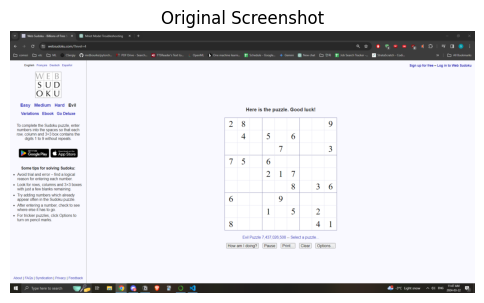

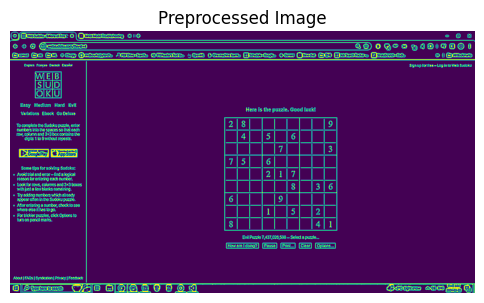

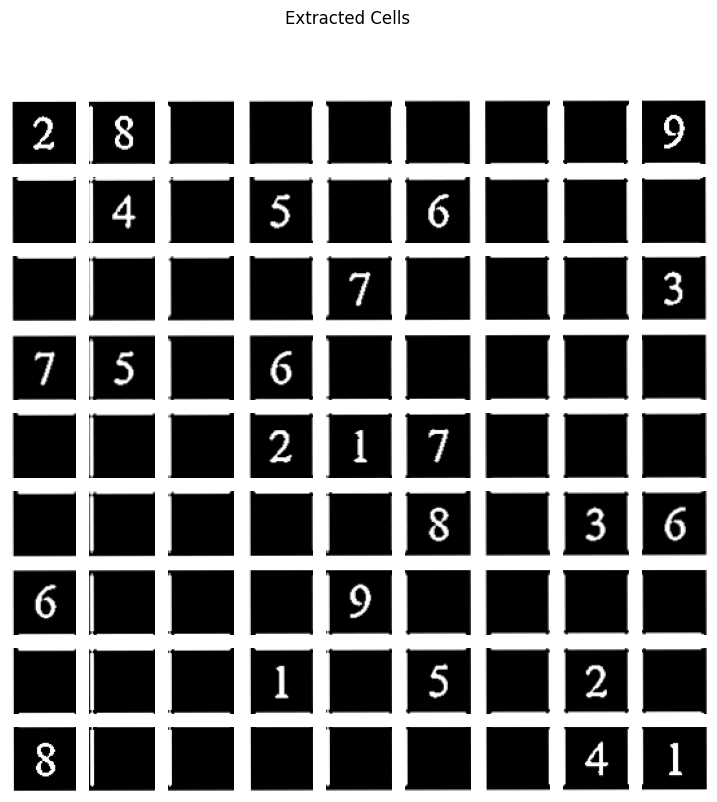

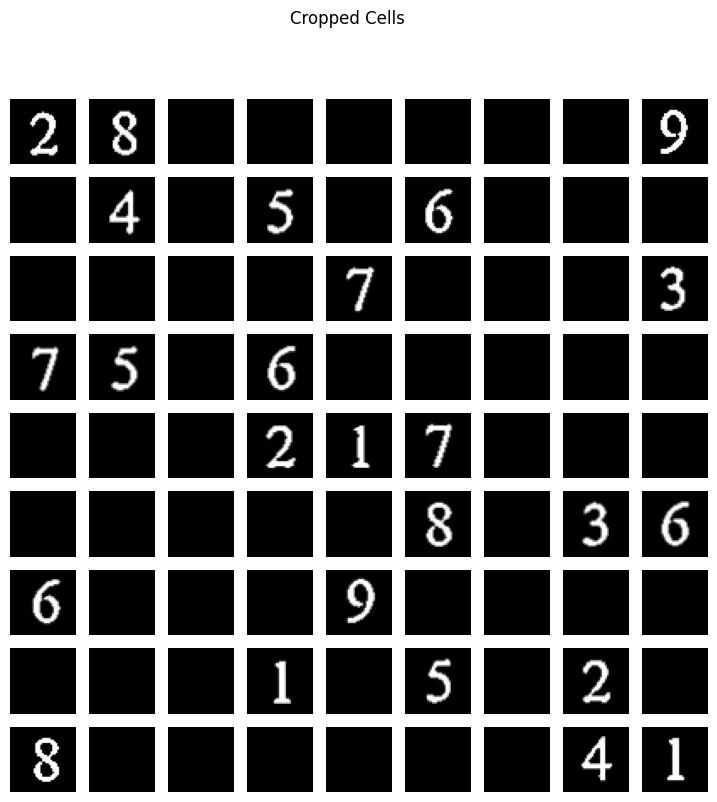


Detecting Empty Cells
# cell contains numbers
- cell is empty

# # - - - - - - # 
- # - # - # - - - 
- - - - # - - - # 
# # - # - - - - - 
- - - # # # - - - 
- - - - - # - # # 
# - - - # - - - - 
- - - # - # - # - 
# - - - - - - # # 


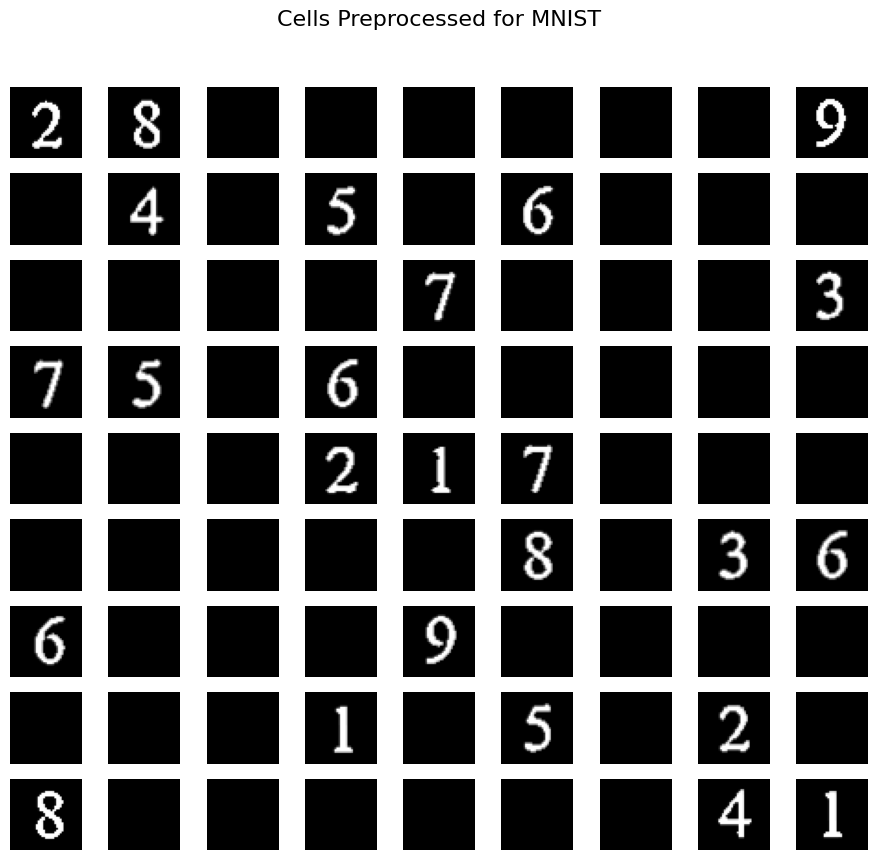

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Sudoku Grid:
2 8 █ | █ █ █ | █ █ 9
█ 4 █ | 5 █ 6 |

In [25]:
# Run the main program
if __name__ == "__main__":
    main()